# Comparison between B3DB and current work
In this section we provide quantitative analysis of the records, identifiers and fingerprints present in B3DB and this work.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem

from utils import COLOUR_B3DB, COLOUR_CNSDB, COLOUR_POSITIVE, COLOUR_NEGATIVE

df_b3db_kc = pd.read_csv("cns_db_split_descriptors.tsv", sep="\t")
df_train = df_b3db_kc[df_b3db_kc.split == "training"].copy().reset_index(drop=True)

[13:23:59] Initializing Normalizer


In [2]:
[z for z in list(df_b3db_kc) if "Num" in z] 

['desc2D_NumValenceElectrons',
 'desc2D_NumRadicalElectrons',
 'desc2D_NumAliphaticCarbocycles',
 'desc2D_NumAliphaticHeterocycles',
 'desc2D_NumAliphaticRings',
 'desc2D_NumAromaticCarbocycles',
 'desc2D_NumAromaticHeterocycles',
 'desc2D_NumAromaticRings',
 'desc2D_NumHAcceptors',
 'desc2D_NumHDonors',
 'desc2D_NumHeteroatoms',
 'desc2D_NumRotatableBonds',
 'desc2D_NumSaturatedCarbocycles',
 'desc2D_NumSaturatedHeterocycles',
 'desc2D_NumSaturatedRings',
 'desc2D_NumAtomStereoCenters',
 'desc2D_NumUnspecifiedAtomStereoCenters',
 'desc2D_NumBridgeheadAtoms',
 'desc2D_NumAmideBonds',
 'desc2D_NumSpiroAtoms']

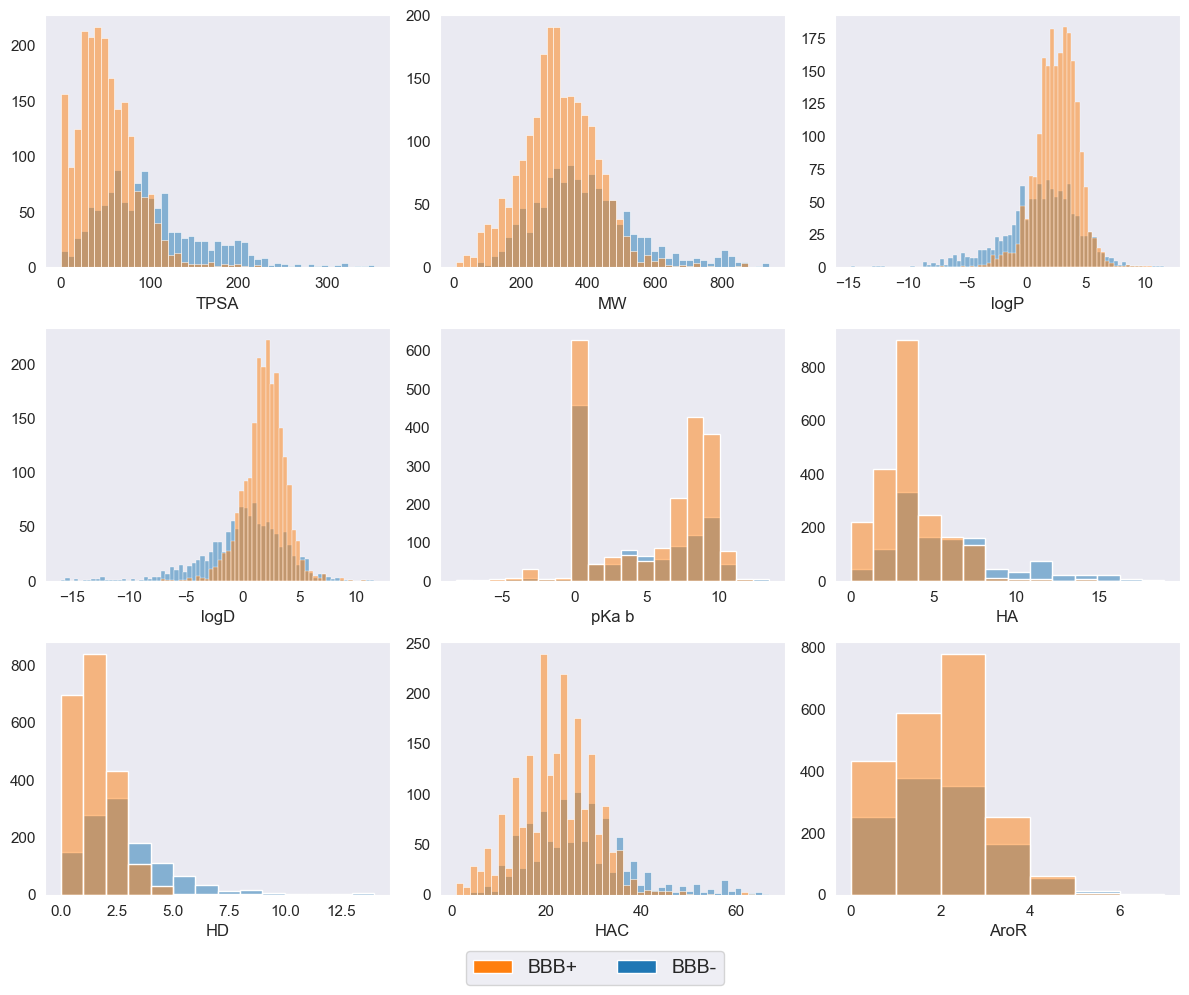

In [4]:
features_of_interest = [
    'desc2D_TPSA',
    'desc2D_MolWt',
    'chemaxon_logp',
    'chemaxon_logd',
    'chemaxon_pka_b',
    'desc2D_NumHAcceptors',
    'desc2D_NumHDonors',
    'desc2D_HeavyAtomCount',
    'desc2D_NumAromaticRings', # for this analysis only
    
    #'desc2D_MinAbsPartialCharge',
    #'desc2D_MaxEStateIndex',
    #'desc2D_MinEStateIndex',
    # 'desc2D_MinPartialCharge',
    # 'desc2D_MaxAbsPartialCharge',
    # 'desc2D_AvgIpc',
    # 'desc2D_HallKierAlpha',
    # 'desc2D_qed',
    # 'desc2D_MinAbsEStateIndex',
    # 'desc2D_NumRotatableBonds',
    # 'desc2D_FractionCSP3',
    # 'desc2D_BalabanJ',
    # 'desc2D_NumSaturatedRings',
    # 'desc2D_NumAliphaticHeterocycles',
    # 'desc2D_NumAliphaticCarbocycles',
    # 'desc2D_NumSpiroAtoms',
    # 'desc2D_NumBridgeheadAtoms',
    # 'desc2D_NumUnspecifiedAtomStereoCenters',
    # 'desc2D_NumAtomStereoCenters',
    # 'desc2D_NumRadicalElectrons',
    # 'desc2D_NumAmideBonds',
    #'desc2D_SPS'
]

f_rename_dict = {
    'desc2D_TPSA': "TPSA",
    'desc2D_MolWt': "MW",
    'chemaxon_logp': "logP",
    'chemaxon_logd': "logD",
    'chemaxon_pka_b': "pKa b",
    'desc2D_NumHAcceptors': "HA",
    'desc2D_NumHDonors': "HD",
    'desc2D_HeavyAtomCount': "HAC",
    'desc2D_NumAromaticRings': "AroR",
}
df_b3db_foi = df_b3db_kc[features_of_interest + ['BBB+/BBB-']].rename(columns=f_rename_dict)

n_cols = 3
n_rows = len(features_of_interest) // n_cols + (len(features_of_interest) % n_cols > 0)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 10), sharex=False, sharey=False)

# Plot each feature's density on a grid
for i, feature in enumerate(features_of_interest):
    row, col = divmod(i, n_cols)
    sns.histplot(
        data=df_b3db_foi, x=f_rename_dict[feature],
        hue='BBB+/BBB-', fill=True, ax=axes[row, col],
        bins=14 if f_rename_dict[feature] in {"HA", "HD"} else 7 if f_rename_dict[feature] == "AroR" else "auto",
        palette={"BBB+": COLOUR_POSITIVE, "BBB-": COLOUR_NEGATIVE},
        legend=False  # Remove individual legends
    )
    # Remove grid from each subplot
    axes[row, col].grid(False)
    # Remove "Count" from y-axis
    axes[row, col].set_ylabel('')
    axes[row, col].tick_params(axis='both', which='major', labelsize=11)
    axes[row, col].set_xlabel(axes[row, col].get_xlabel(), fontsize=12)


# Remove empty subplots if any
for i in range(len(features_of_interest), n_rows * n_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()

# Add a single legend to the figure at the bottom center
# Create custom legend patches
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=COLOUR_POSITIVE, label='BBB+'),
    Patch(facecolor=COLOUR_NEGATIVE, label='BBB-')
]
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=2, fontsize=14)

# Adjust layout to make room for the legend
plt.subplots_adjust(bottom=0.1)
plt.savefig('figures/figure_6.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()
# Plot the correlation matrix
#sns.pairplot(df_b3db_kc[ features_of_interest + ['BBB+/BBB-']], hue='BBB+/BBB-', markers=["o", "s"])

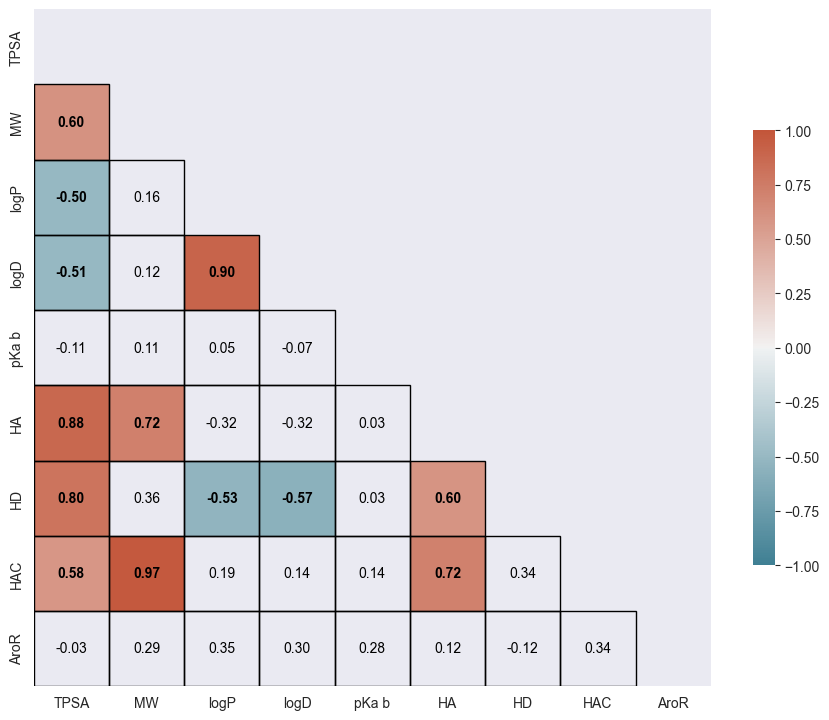

In [5]:
import numpy as np

corr_matrix = df_b3db_foi.drop(columns=["BBB+/BBB-"]).corr()
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Create mask for upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 9))

# Create a mask that combines the upper triangle mask with weak correlation mask
combined_mask = mask | (np.abs(corr_matrix) <= 0.4)

# Draw the heatmap only for strong correlations (|r| > 0.3)
sns.heatmap(corr_matrix, mask=combined_mask, annot=False, fmt=".2f",
            cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=0, cbar_kws={"shrink": .5}, ax=ax)

# Remove grid
ax.grid(False)

# Add annotations for all visible cells (both strong and weak correlations)
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.index)):
        if not mask[i, j]:  # Only for lower triangle (all values)
            text = f'{corr_matrix.iloc[i, j]:.2f}'

            font_weight = 'normal' if np.abs(corr_matrix.iloc[i, j]) <= 0.4 else 'bold'

            ax.text(j + 0.5, i + 0.5, text, ha='center', va='center',
                   color='black', fontsize=10, weight=font_weight)

            # Add rectangle border around the cell
            from matplotlib.patches import Rectangle
            rect = Rectangle((j, i), 1, 1, linewidth=1.0, edgecolor='black',
                           facecolor='none')
            ax.add_patch(rect)

#plt.title('Correlation Matrix ', fontsize=14)
plt.tight_layout()
plt.savefig('figures/figure_7.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [16]:
import rdkit
from rdkit.Chem import rdMolDescriptors
limited_features_of_interest = ["TPSA", "MW", "HA", "HD", "HAC", "AroR"]
df_b3db = pd.read_csv("../data/B3DB/B3DB/B3DB_classification.tsv", sep="\t")
df_b3db["mol"] = df_b3db["SMILES"].apply(lambda x: rdkit.Chem.MolFromSmiles(x))

_n_pre_removal = len(df_b3db)
df_b3db = df_b3db[df_b3db.mol.apply(pd.notna)]
print(f"Removed {len(df_b3db) - _n_pre_removal}  ({_n_pre_removal} -> {len(df_b3db)}) molecules where SMILES could not be converted to molecule objects")
df_b3db["TPSA"] = df_b3db.mol.apply(rdMolDescriptors.CalcTPSA)
df_b3db["MW"] = df_b3db.mol.apply(rdMolDescriptors.CalcExactMolWt)
df_b3db["HA"] = df_b3db.mol.apply(rdMolDescriptors.CalcNumHBA)
df_b3db["HD"] = df_b3db.mol.apply(rdMolDescriptors.CalcNumHBD)
df_b3db["HAC"] = df_b3db.mol.apply(rdMolDescriptors.CalcNumHeavyAtoms)
df_b3db["AroR"] = df_b3db.mol.apply(rdMolDescriptors.CalcNumAromaticRings)
df_b3db_foi["source"] = "CNS-DB"
df_b3db["source"] = "B3DB"
_df = pd.concat([
    df_b3db_foi[limited_features_of_interest + ["BBB+/BBB-", "source"]],
    df_b3db[limited_features_of_interest + ["BBB+/BBB-", "source"]]
], axis=0)
_df[["BBB+/BBB-", "source"]].value_counts()
#_df.head()

[16:00:47] Explicit valence for atom # 10 C, 4, is greater than permitted
[16:00:47] Explicit valence for atom # 10 C, 4, is greater than permitted


Removed -2  (7807 -> 7805) molecules where SMILES could not be converted to molecule objects


BBB+/BBB-  source
BBB+       B3DB      4956
BBB-       B3DB      2849
BBB+       CNS-DB    2115
BBB-       CNS-DB    1207
Name: count, dtype: int64

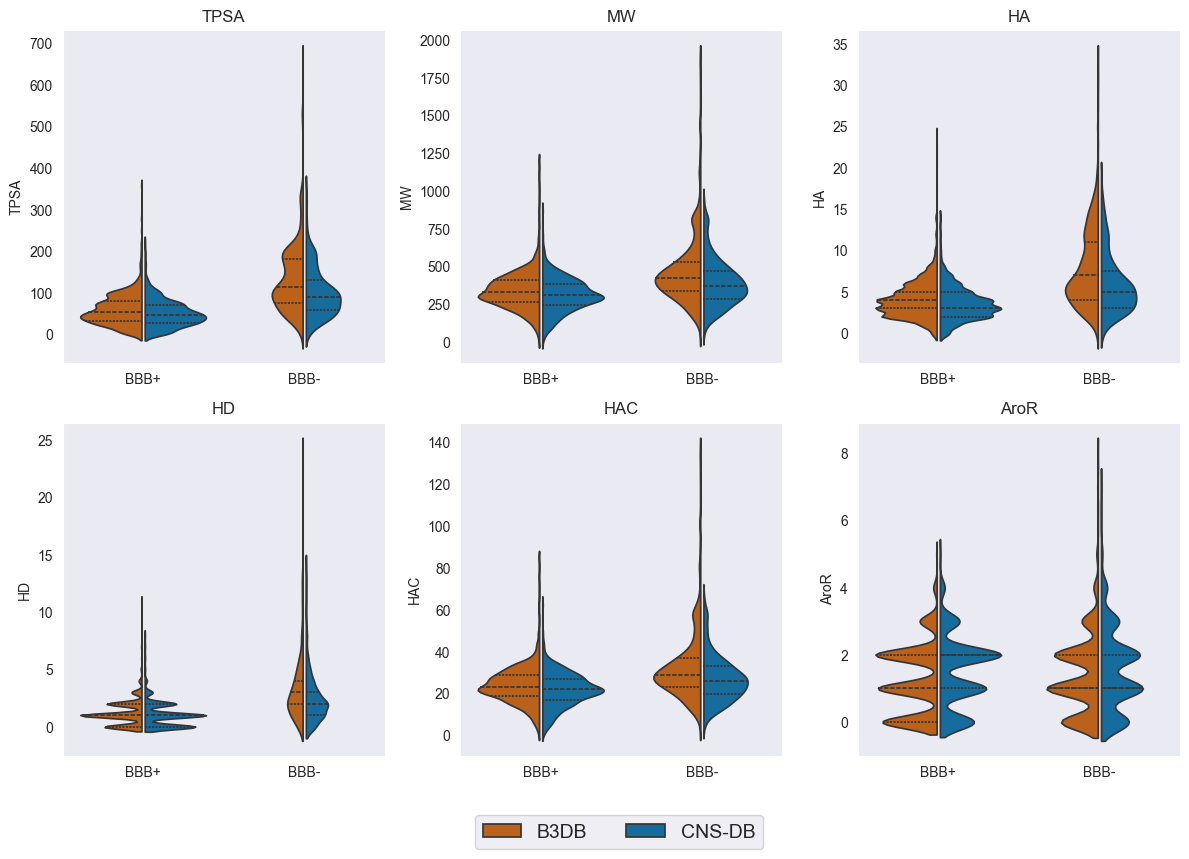

In [18]:
n_cols = 3
n_rows = len(limited_features_of_interest) // n_cols + (len(limited_features_of_interest) % n_cols > 0)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8), sharex=False, sharey=False)

for i, f in enumerate(limited_features_of_interest):
    row, col = divmod(i, n_cols)

    sns.violinplot(
        data=_df[[f, "BBB+/BBB-", "source"]],
        ax=axes[row, col], y=f , x="BBB+/BBB-",
        hue="source", hue_order=["B3DB", "CNS-DB"],
        gap=0.05, split=True, inner="quart",
        palette={"B3DB": COLOUR_B3DB, "CNS-DB": COLOUR_CNSDB}
    )

    axes[row, col].set_xlabel("")
    axes[row, col].set_title(f)
    axes[row, col].get_legend().remove()
    axes[row, col].grid(False)


for i in range(len(limited_features_of_interest), n_rows * n_cols):
    fig.delaxes(axes.flatten()[i])

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.52, -0.08), ncol=len(labels), fontsize=14)

plt.subplots_adjust(bottom=0.1)
plt.tight_layout()
plt.savefig('figures/figure_9.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()
